In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import numpy as np
import scipy.optimize as spo
import wandb
import os
import glob
import torch
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

from learning_from_data.train import NNTrainingModule
from theoretical_analysis import plot_step_function
import theoretical_analysis.planted_submatrix_analysis as submatrix
import theoretical_analysis.sparse_nnpca_analysis as gaussiannnpca

plot_dir = Path("plots/")
plot_dir.mkdir(parents=True, exist_ok=True)
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.serif"] = ["Computer Modern Roman"]
matplotlib.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath} \usepackage{amssymb} \usepackage{mathptmx}"
)
figsize = (4, 3)
axes_rect = [0.2, 0.1, 0.7, 0.8]

/cis/home/yma93/miniconda3/envs/nonlinear_laplacian/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Planted Submatrix
## Z-shaped piecewise linear function
Consider $\sigma(x) = \begin{cases} 0 & x< c\\ b\frac{x-c}{a}& c<x<a+c \\ b & x>a+c\end{cases}$

0.7650237606415122 [ 7.41704791  4.40851134 -5.20518863]


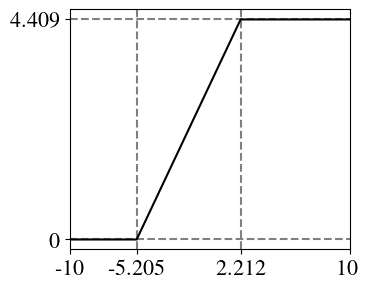

In [3]:
with open("logs/planted_submatrix/optimization_zshape.pkl", "rb") as f:
    res = pickle.load(f)
print(res.fun, res.x)
gamma = res.x
x = np.arange(-10, 10, 0.01)
y = [min(gamma[1], max(0, gamma[1] / gamma[0] * (x_i - gamma[2]))) for x_i in x]
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(axes_rect)
ax.plot(x, y, color="black")
ax.set_xticks([-10, res.x[2], res.x[0] + res.x[2], 10])
ax.set_yticks([0, res.x[1]])
ax.set_xticklabels([-10, f"{res.x[2]:.3f}", f"{res.x[0] + res.x[2]:.3f}", 10], fontsize=16)
ax.set_yticklabels([0, f"{res.x[1]:.3f}"], fontsize=16)

ax.vlines(res.x[2], -0.2, res.x[1] + 0.2, linestyle="--", color="grey", zorder=1)
ax.vlines(res.x[0] + res.x[2], -0.2, res.x[1] + 0.4, linestyle="--", color="gray", zorder=1)
ax.hlines(res.x[1], -10, 10, linestyle="--", color="gray", zorder=1)
ax.hlines(0, -10, 10, linestyle="--", color="gray", zorder=1)
ax.set_ylim(-0.2, res.x[1] + 0.2)
ax.set_xlim(-10, 10)
fig.savefig(plot_dir / "planted_submatrix_zshape.pdf")
plt.show()
plt.close(fig)

### Heatmaps

In [4]:
def plot_heatmap(data, extent, xlabel, ylabel, title, filename, cmap, norm):
    plt.imshow(
        data,
        extent=extent,
        origin="lower",
        aspect="auto",
        cmap=cmap,
        norm=norm,
    )
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Add colorbar with custom ticks
    cbar = plt.colorbar(label=r"$\beta^*$")
    cbar.ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: rf"$\geq 1$" if x == 1 else f"{x:.2f}")
    )
    cbar.set_label(r"$\beta^*$", fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.savefig(plot_dir / filename)
    plt.show()

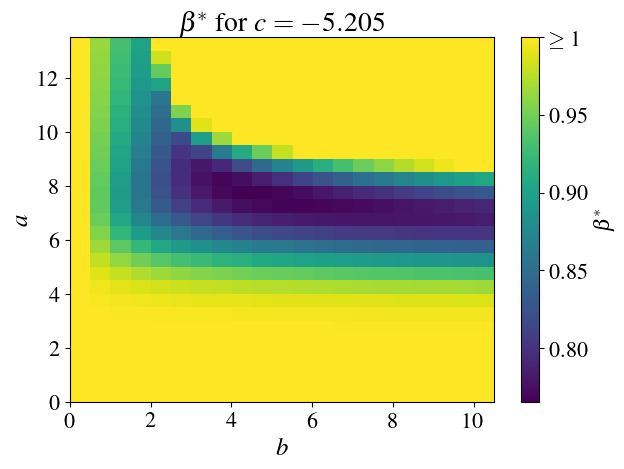

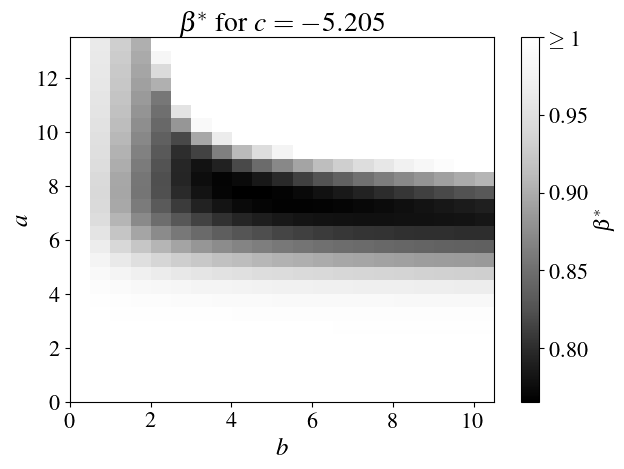

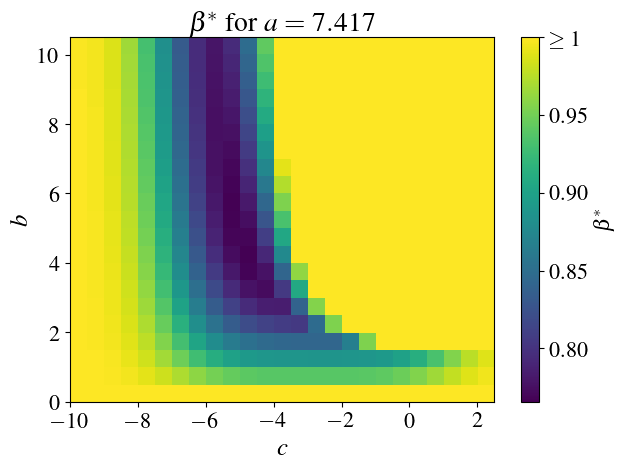

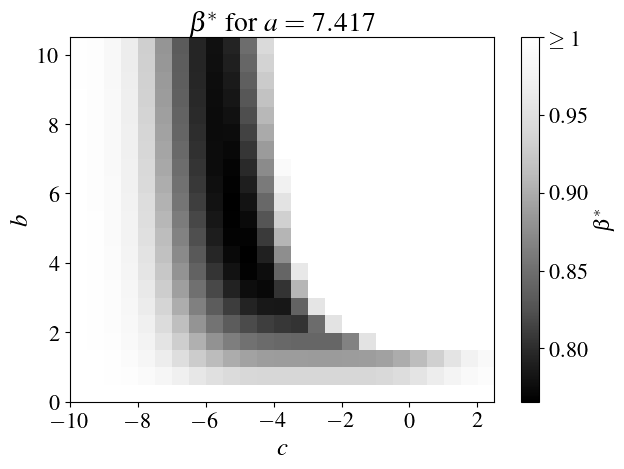

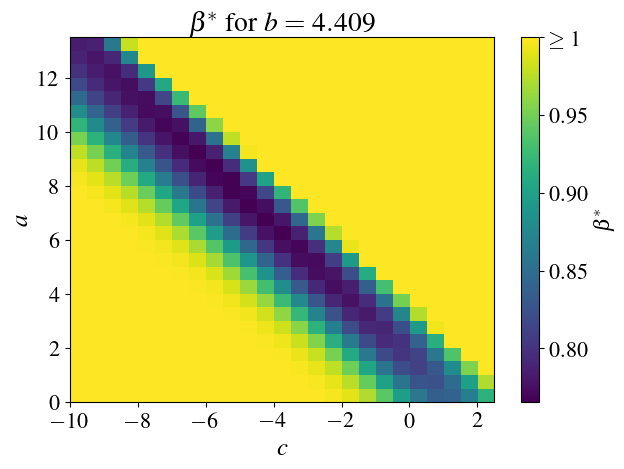

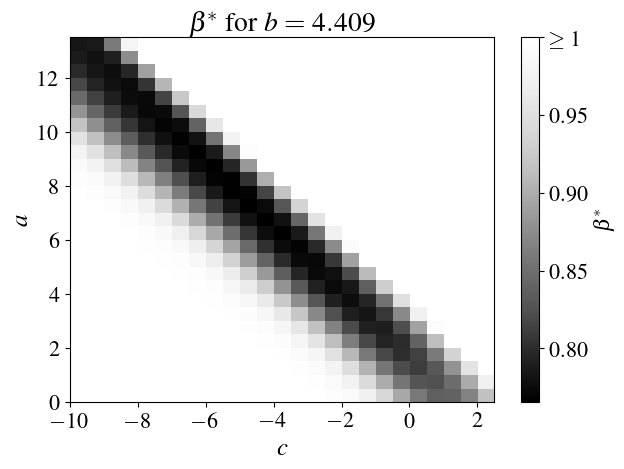

In [5]:
# Load optimization results
with open("logs/planted_submatrix/optimization_zshape.pkl", "rb") as f:
    res = pickle.load(f)

# First heatmap
a_range, b_range, fix_c = pickle.load(
    open(f"logs/planted_submatrix/c_criticals_c={res.x[-1]}.pkl", "rb")
)
norm = mcolors.Normalize(vmin=fix_c.min(), vmax=1)  # Normalize with max capped at 1

# Color version
plot_heatmap(
    fix_c,
    extent=[b_range[0], b_range[-1], a_range[0], a_range[-1]],
    xlabel=r"$b$",
    ylabel=r"$a$",
    title=rf"$\beta^*$ for $c={res.x[-1]:.3f}$",
    filename="planted_submatrix_zshape_fix_c_color.pdf",
    cmap="viridis",
    norm=norm,
)

# Black and white version
plot_heatmap(
    fix_c,
    extent=[b_range[0], b_range[-1], a_range[0], a_range[-1]],
    xlabel=r"$b$",
    ylabel=r"$a$",
    title=rf"$\beta^*$ for $c={res.x[-1]:.3f}$",
    filename="planted_submatrix_zshape_fix_c_bw.pdf",
    cmap="Greys_r",
    norm=norm,
)

# Second heatmap
b_range, c_range, fix_a = pickle.load(
    open(f"logs/planted_submatrix/c_criticals_a={res.x[0]}.pkl", "rb")
)
norm = mcolors.Normalize(vmin=fix_a.min(), vmax=1)  # Normalize with max capped at 1

# Color version
plot_heatmap(
    fix_a,
    extent=[c_range[0], c_range[-1], b_range[0], b_range[-1]],
    xlabel=r"$c$",
    ylabel=r"$b$",
    title=rf"$\beta^*$ for $a={res.x[0]:.3f}$",
    filename="planted_submatrix_zshape_fix_a_color.pdf",
    cmap="viridis",
    norm=norm,
)

# Black and white version
plot_heatmap(
    fix_a,
    extent=[c_range[0], c_range[-1], b_range[0], b_range[-1]],
    xlabel=r"$c$",
    ylabel=r"$b$",
    title=rf"$\beta^*$ for $a={res.x[0]:.3f}$",
    filename="planted_submatrix_zshape_fix_a_bw.pdf",
    cmap="Greys_r",
    norm=norm,
)

# Third heatmap
a_range, c_range, fix_b = pickle.load(
    open(f"logs/planted_submatrix/c_criticals_b={res.x[1]}.pkl", "rb")
)
norm = mcolors.Normalize(vmin=fix_b.min(), vmax=1)  # Normalize with max capped at 1

# Color version
plot_heatmap(
    fix_b,
    extent=[c_range[0], c_range[-1], a_range[0], a_range[-1]],
    xlabel=r"$c$",
    ylabel=r"$a$",
    title=rf"$\beta^*$ for $b={res.x[1]:.3f}$",
    filename="planted_submatrix_zshape_fix_b_color.pdf",
    cmap="viridis",
    norm=norm,
)

# Black and white version
plot_heatmap(
    fix_b,
    extent=[c_range[0], c_range[-1], a_range[0], a_range[-1]],
    xlabel=r"$c$",
    ylabel=r"$a$",
    title=rf"$\beta^*$ for $b={res.x[1]:.3f}$",
    filename="planted_submatrix_zshape_fix_b_bw.pdf",
    cmap="Greys_r",
    norm=norm,
)

## $a\tanh(bx)$

In [6]:
with open("logs/planted_submatrix/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
print(res.fun, res.x)

0.7550073892984475 [1.70974534 0.58384117]


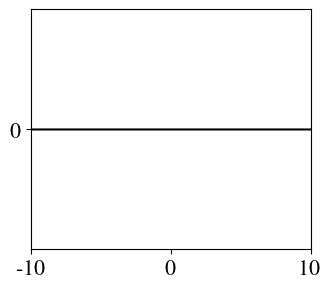

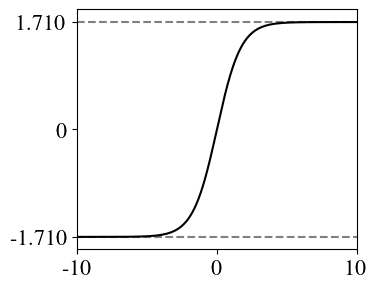

In [7]:
# plot zero sigma and learned sigma
x = np.arange(-10, 10, 0.01)

# Plot zero sigma
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(axes_rect)
ax.plot(x, np.zeros_like(x), color="black")
# ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$\sigma(x)$")
ax.set_xticks([-10, 0, 10])
ax.set_xticklabels([-10, 0, 10], fontsize=16)
ax.set_yticks([0])
ax.set_yticklabels([0], fontsize=16)
ax.set_xlim(-10, 10)
fig.savefig(plot_dir / "zero_sigma.pdf")
plt.show()
plt.close(fig)

# Plot learned sigma
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(axes_rect)
ax.plot(x, res.x[0] * np.tanh(res.x[1] * x), color="black")
# ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$\sigma(x)$")
ax.set_xticks([-10, 0, 10])
ax.set_xticklabels([-10, 0, 10], fontsize=16)
ax.set_yticks([-res.x[0], 0, res.x[0]])
ax.set_yticklabels([f"{-res.x[0]:.3f}", "0", f"{res.x[0]:.3f}"], fontsize=16)
ax.hlines(-res.x[0], -10, 10, linestyle="--", color="gray", zorder=1)
ax.hlines(res.x[0], -10, 10, linestyle="--", color="gray", zorder=1)
ax.set_xlim(-10, 10)
ax.set_ylim(-res.x[0] - 0.2, res.x[0] + 0.2)
fig.savefig(plot_dir / "planted_submatrx_tanh.pdf")
plt.show()
plt.close(fig)

### Histogram of eigenvalues

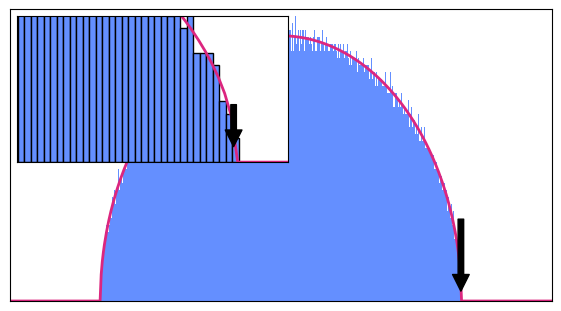

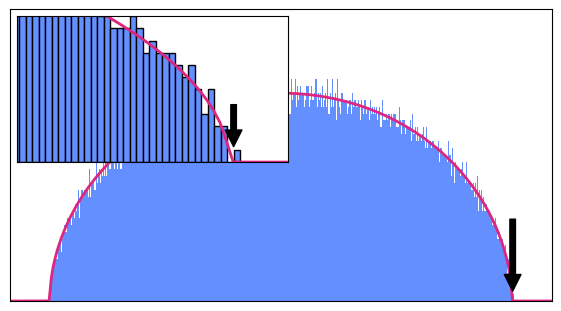

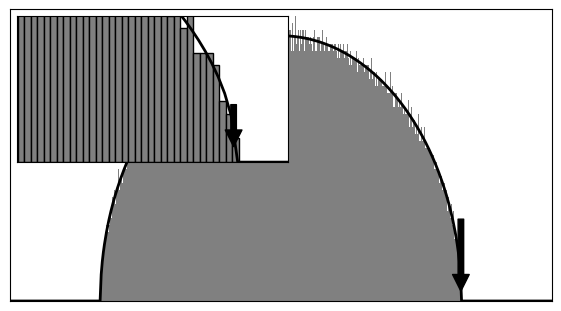

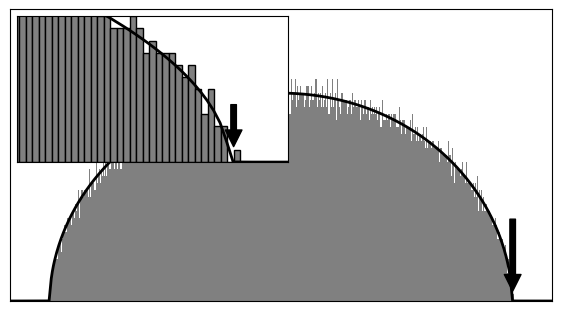

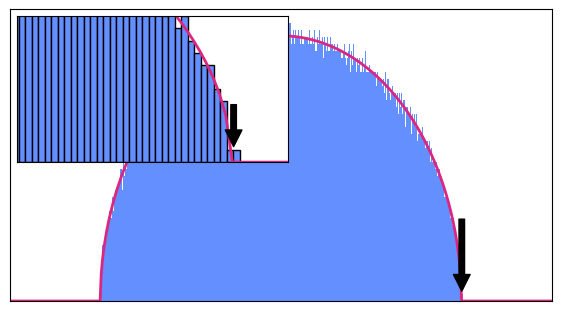

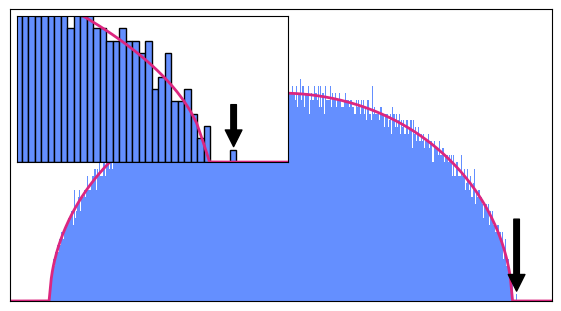

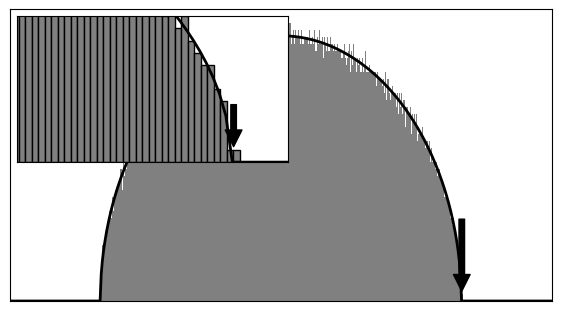

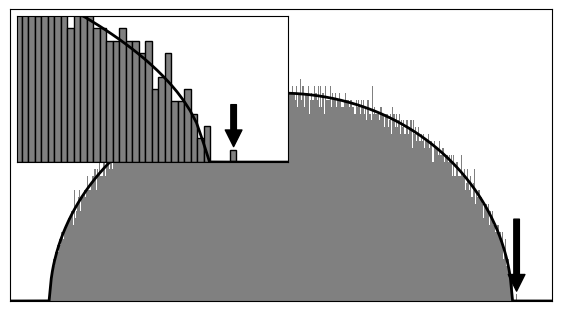

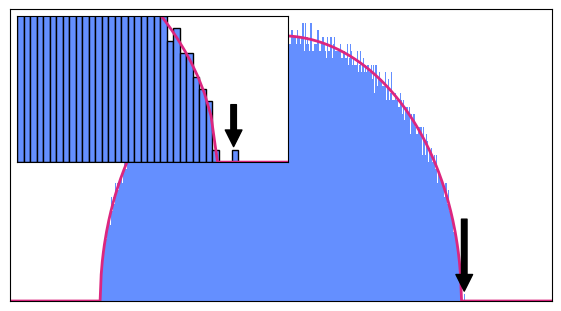

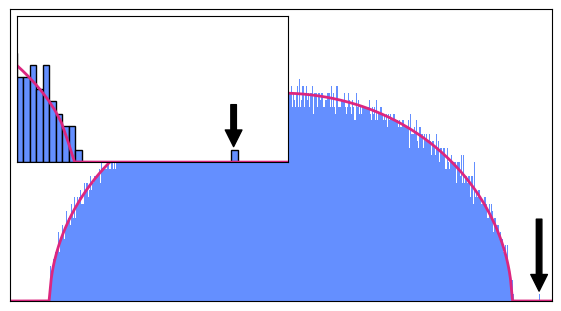

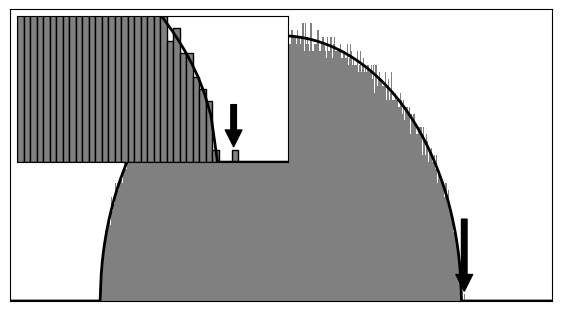

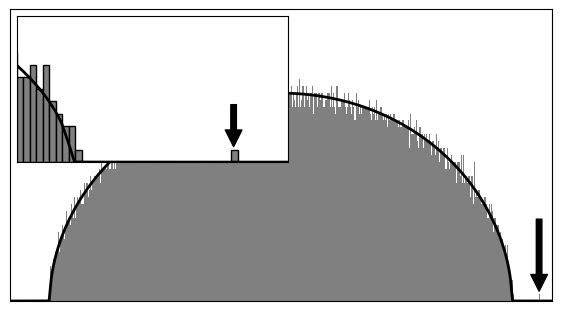

In [8]:
def plot_histograms(results, beta, fname, use_bw=False):
    # Define colors and styles based on the mode
    hist_color = "#648FFF" if not use_bw else "grey"
    line_color = "#dc267f" if not use_bw else "black"
    arrow_color = "black"
    edge_color = "black"  # Outline color for the bins

    # Plot for A_p_evals
    A_p_evals, L_p_evals, x, sc, free_conv = results[beta]
    fig, ax = plt.subplots(figsize=(5.5, 3), constrained_layout=True)
    ax.hist(
        A_p_evals,
        bins=500,
        density=True,
        color=hist_color,
        label="Histogram of eigenvalues",
        range=(-3, 3),
    )
    ax.annotate(
        "",
        xy=(A_p_evals[-1], 0.01),
        xytext=(A_p_evals[-1], 0.1),
        arrowprops=dict(facecolor=arrow_color, shrink=0.02),
    )
    ax.plot(x, sc, label="Analytic prediction", color=line_color, linewidth=2)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 0.35)
    ax.set_xticks([])
    ax.set_yticks([])

    # Inset for zoomed-in A_p_evals
    ax_inset = inset_axes(ax, width="50%", height="50%", loc="upper left")
    ax_inset.hist(
        A_p_evals,
        bins=500,
        density=True,
        color=hist_color,
        edgecolor=edge_color,  # Add outline to bins
        range=(-3, 3),
    )
    ax_inset.annotate(
        "",
        xy=(A_p_evals[-1], 0.01),
        xytext=(A_p_evals[-1], 0.04),
        arrowprops=dict(facecolor=arrow_color, shrink=0.02),
    )
    ax_inset.plot(x, sc, color=line_color, linewidth=2)
    ax_inset.set_xlim(A_p_evals[-1] - 0.4, A_p_evals[-1] + 0.1)
    ax_inset.set_ylim(0, 0.1)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    suffix = "_bw" if use_bw else "_color"
    fig.savefig(plot_dir / f"direct_beta={beta}_combined{suffix}.pdf")
    plt.show()
    plt.close(fig)

    # Plot for L_p_evals
    fig, ax = plt.subplots(figsize=(5.5, 3), constrained_layout=True)
    ax.hist(
        L_p_evals,
        bins=500,
        density=True,
        color=hist_color,
        label="Histogram of eigenvalues",
        range=(-3, 3),
    )
    ax.annotate(
        "",
        xy=(L_p_evals[-1], 0.01),
        xytext=(L_p_evals[-1], 0.1),
        arrowprops=dict(facecolor=arrow_color, shrink=0.02),
    )
    ax.plot(x, free_conv, label="Analytic prediction", color=line_color, linewidth=2)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 0.35)
    ax.set_xticks([])
    ax.set_yticks([])

    # Inset for zoomed-in L_p_evals
    ax_inset = inset_axes(ax, width="50%", height="50%", loc="upper left")
    ax_inset.hist(
        L_p_evals,
        bins=500,
        density=True,
        color=hist_color,
        edgecolor=edge_color,  # Add outline to bins
        range=(-3, 3),
    )
    ax_inset.annotate(
        "",
        xy=(L_p_evals[-1], 0.01),
        xytext=(L_p_evals[-1], 0.04),
        arrowprops=dict(facecolor=arrow_color, shrink=0.02),
    )
    ax_inset.plot(x, free_conv, color=line_color, linewidth=2)
    ax_inset.set_xlim(L_p_evals[-1] - 0.4, L_p_evals[-1] + 0.1)
    ax_inset.set_ylim(0, 0.1)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    fig.savefig(fname)
    plt.show()
    plt.close(fig)


# Load data
with open(f"logs/planted_submatrix/tanh_eigenvalues_n=10000.pkl", "rb") as f:
    results = pickle.load(f)

# Generate plots for each beta
for beta in results.keys():
    # Color version
    plot_histograms(
        results,
        beta,
        plot_dir / f"planted_submatrix_tanh_histogram_beta={beta}_color.pdf",
        use_bw=False,
    )

    # Black-and-white version
    plot_histograms(
        results,
        beta,
        plot_dir / f"planted_submatrix_tanh_histogram_beta={beta}_bw.pdf",
        use_bw=True,
    )

### Phase transition for eigenvalue and eigenvector

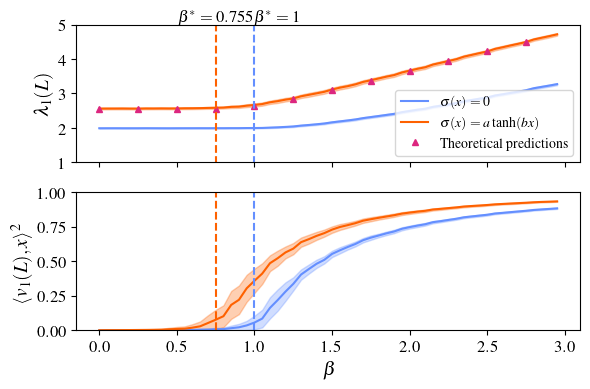

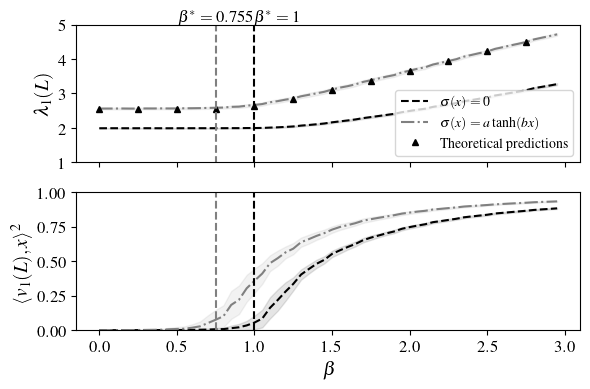

In [10]:
def plot_eigenvalues_and_vectors(results, betas, res, filename, use_bw=False):
    fig, ax = plt.subplots(2, 1, figsize=(6, 4))

    # Define colors or grayscale styles
    color_sigma_0 = "#648fff" if not use_bw else "black"
    color_sigma_tanh = "#fe6100" if not use_bw else "gray"
    prediction_color = "#dc267f" if not use_bw else "black"
    linestyle_sigma_0 = "-" if not use_bw else "--"
    linestyle_sigma_tanh = "-" if not use_bw else "-."
    prediction_marker = "^"

    # First plot
    ax[0].plot(
        betas,
        [results[beta][0].mean() for beta in betas],
        label=r"$\sigma(x)=0$",
        color=color_sigma_0,
        linestyle=linestyle_sigma_0,
    )
    ax[0].fill_between(
        betas,
        [results[beta][0].mean() - results[beta][0].std() for beta in betas],
        [results[beta][0].mean() + results[beta][0].std() for beta in betas],
        alpha=0.3 if not use_bw else 0.1,
        color=color_sigma_0,
    )
    ax[0].plot(
        betas,
        [results[beta][2].mean() for beta in betas],
        label=r"$\sigma(x)=a\tanh(bx)$",
        color=color_sigma_tanh,
        linestyle=linestyle_sigma_tanh,
    )
    ax[0].fill_between(
        betas,
        [results[beta][2].mean() - results[beta][2].std() for beta in betas],
        [results[beta][2].mean() + results[beta][2].std() for beta in betas],
        alpha=0.3 if not use_bw else 0.1,
        color=color_sigma_tanh,
    )
    ax[0].plot(
        betas[::5],
        [results[beta][4] for beta in betas][::5],
        label="Theoretical predictions",
        color=prediction_color,
        marker=prediction_marker,
        markersize=5,
        linestyle="None",
    )

    # Second plot
    ax[1].plot(
        betas,
        [results[beta][1].mean() for beta in betas],
        label=r"$\sigma(x)=0$",
        color=color_sigma_0,
        linestyle=linestyle_sigma_0,
    )
    ax[1].fill_between(
        betas,
        [results[beta][1].mean() - results[beta][1].std() for beta in betas],
        [results[beta][1].mean() + results[beta][1].std() for beta in betas],
        alpha=0.3 if not use_bw else 0.1,
        color=color_sigma_0,
    )
    ax[1].plot(
        betas,
        [results[beta][3].mean() for beta in betas],
        label=r"$\sigma(x)=a\tanh(bx)$",
        color=color_sigma_tanh,
        linestyle=linestyle_sigma_tanh,
    )
    ax[1].fill_between(
        betas,
        [results[beta][3].mean() - results[beta][3].std() for beta in betas],
        [results[beta][3].mean() + results[beta][3].std() for beta in betas],
        alpha=0.3 if not use_bw else 0.1,
        color=color_sigma_tanh,
    )

    # Vertical lines
    ax[0].vlines(1, 0, 5, linestyle="--", color=color_sigma_0)
    ax[0].vlines(res.fun, 0, 5, linestyle="--", color=color_sigma_tanh)
    ax[1].vlines(1, 0, 1, linestyle="--", color=color_sigma_0)
    ax[1].vlines(res.fun, 0, 1, linestyle="--", color=color_sigma_tanh)

    # Text annotations
    ax[0].text(1, 5.1, r"$\beta^*=1$", color="black", ha="left", fontsize=12)
    ax[0].text(res.fun, 5.1, rf"$\beta^*={res.fun:.3f}$", color="black", ha="center", fontsize=12)

    # Axis limits and labels
    ax[0].set_ylim(1, 5)
    ax[1].set_ylim(0, 1)
    ax[0].set_ylabel(r"$\lambda_1(L)$", fontsize=14)
    ax[1].set_ylabel(r"$\langle {v}_1(L), {x} \rangle^2$", fontsize=14)
    ax[1].set_xlabel(r"$\beta$", fontsize=14)
    ax[0].set_xticklabels([])
    ax[1].tick_params(axis="x", labelsize=12)
    ax[0].tick_params(axis="y", labelsize=12)
    ax[1].tick_params(axis="y", labelsize=12)

    # Legend
    ax[0].legend(loc="lower right", fontsize=10)

    # Save and show
    plt.savefig(filename)
    plt.tight_layout()
    plt.show()


# Load data
n = 2000
N = 500
np.random.seed(0)
betas = np.arange(0, 3, 0.05)
with open("logs/planted_submatrix/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
with open(f"logs/planted_submatrix/tanh_top_eigen_n={n}_N={N}.pkl", "rb") as f:
    results = pickle.load(f)

# Generate color version
plot_eigenvalues_and_vectors(
    results,
    betas,
    res,
    filename=plot_dir / "planted_submatrix_tanh_eigenvectors_color.pdf",
    use_bw=False,
)

# Generate black-and-white version
plot_eigenvalues_and_vectors(
    results,
    betas,
    res,
    filename=plot_dir / "planted_submatrix_tanh_eigenvectors_bw.pdf",
    use_bw=True,
)

## Step functions

[0.7556009473867566, 0.7548625372061667, 0.7553876659806942, 0.7563341754192751, 0.756337667071246, 0.7558085243867668, 0.7563286718712805, 0.7556918737317009, 0.7554804842983758, 0.7561053316554172]
0.7548625372061667


/cis/home/yma93/projects/gnn-planted-clique/theoretical_analysis/__init__.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


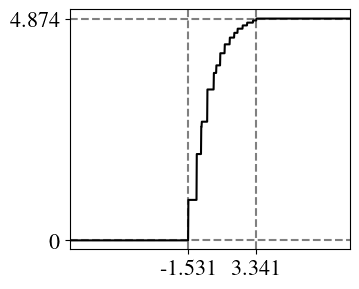

In [11]:
with open("logs/planted_submatrix/optimization_step.pkl", "rb") as f:
    results = pickle.load(f)
results_list = [results[str(seed)][2].fun for seed in range(10)]
print(results_list)
argmin_seed = np.argmin(results_list)
print(results_list[argmin_seed])
plot_step_function(
    np.array(results[str(argmin_seed)][2].x),
    plot_dir / "planted_submatrix_step_function_NM_n=15.pdf",
    figsize=figsize,
    axes_rect=axes_rect,
)

# Gaussian Sparse NNPCA
Sparse NNPCA with $\eta = \mathrm{Law}(|g|), g\sim N(0,1), p=\beta/\sqrt{n}$

## $a\tanh(bx)$

In [12]:
with open("logs/gaussian_sparse_nnpca/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
print(res.fun, res.x)

0.661658086101911 [2.17506053 0.57475203]


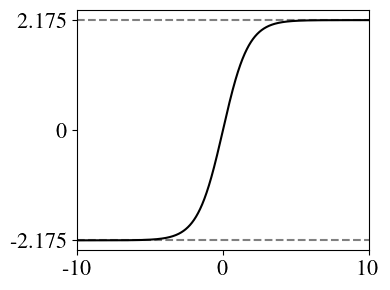

In [14]:
x = np.arange(-10, 10, 0.01)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(x, res.x[0] * np.tanh(res.x[1] * x), color="black")
# ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$\sigma(x)$")
ax.set_xticks([-10, 0, 10])
ax.set_xticklabels([-10, 0, 10], fontsize=16)
ax.set_yticks([-res.x[0], 0, res.x[0]])
ax.set_yticklabels([f"{-res.x[0]:.3f}", "0", f"{res.x[0]:.3f}"], fontsize=16)
ax.hlines(-res.x[0], -10, 10, linestyle="--", color="gray", zorder=1)
ax.hlines(res.x[0], -10, 10, linestyle="--", color="gray", zorder=1)
ax.set_xlim(-10, 10)
ax.set_ylim(-res.x[0] - 0.2, res.x[0] + 0.2)
fig.tight_layout()
fig.savefig(plot_dir / "gaussian_sparse_nnpca_tanh.pdf")
plt.show()
plt.close(fig)

### Transferability analysis

In [15]:
# Use sigma learned from gaussian sparse NNPCA on planted submatrix
with open("logs/gaussian_sparse_nnpca/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
    print(f"beta^* for gaussian sparse NNPCA:{res.fun}")
    beta_star = submatrix.c_critical(
        c_range=[0.5, 1],
        sigma=lambda x: res.x[0] * np.tanh(res.x[1] * x),
        sigma_image=[-res.x[0], res.x[0]],
        plot=False,
    )
print(f"beta^* for planted submatrix: {beta_star}")

beta^* for gaussian sparse NNPCA:0.661658086101911
beta^* for planted submatrix: 0.766690339565534


In [16]:
# Use sigma learned from planted submatrix on gaussian sparse NNPCA
with open("logs/planted_submatrix/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
    print(f"beta^* for planted submatrix:{res.fun}")
    beta_star = gaussiannnpca.c_critical(
        c_range=[0.5, 1],
        sigma=lambda x: res.x[0] * np.tanh(res.x[1] * x),
        sigma_image=[-res.x[0], res.x[0]],
        plot=False,
    )
print(f"beta^* for gaussian sparse NNPCA: {beta_star}")

beta^* for planted submatrix:0.7550073892984475
beta^* for gaussian sparse NNPCA: 0.6732137034008591


### Phase transition for eigenvalue and eigenvectors

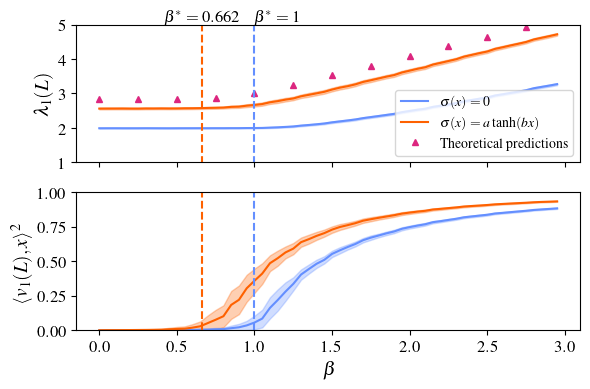

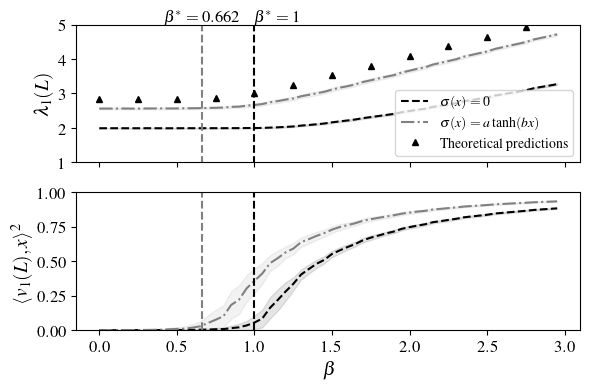

In [17]:
n = 2000
N = 500
np.random.seed(0)
betas = np.arange(0, 3, 0.05)
with open("logs/gaussian_sparse_nnpca/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
with open(f"logs/gaussian_sparse_nnpca/tanh_top_eigen_n={n}_N={N}.pkl", "rb") as f:
    results = pickle.load(f)

# Generate color version
plot_eigenvalues_and_vectors(
    results,
    betas,
    res,
    filename=plot_dir / "gaussian_sparse_nnpca_tanh_eigenvectors_color.pdf",
    use_bw=False,
)

# Generate black-and-white version
plot_eigenvalues_and_vectors(
    results,
    betas,
    res,
    filename=plot_dir / "gaussian_sparse_nnpca_tanh_eigenvectors_bw.pdf",
    use_bw=True,
)

## Step functions

[0.6653413481249374, 0.6651901629454996]
0.6651901629454996


/cis/home/yma93/projects/gnn-planted-clique/theoretical_analysis/__init__.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


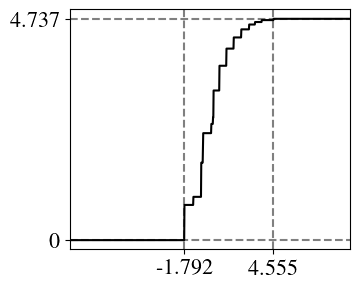

In [18]:
with open("logs/gaussian_sparse_nnpca/optimization_step.pkl", "rb") as f:
    results = pickle.load(f)
results_list = [results[str(seed)][2].fun for seed in range(len(results))]
print(results_list)
argmin_seed = np.argmin(results_list)
print(results_list[argmin_seed])
plot_step_function(
    np.array(results[str(argmin_seed)][2].x),
    plot_dir / "step_function_NM_n=15.pdf",
    figsize=figsize,
    axes_rect=axes_rect,
)